In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

## Autoencoder による冪指数の調査

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
batch_size = 128 # batch size
n_epochs = 100 # number of epochs
lr = 0.01 # learning rate
n_hid = 100 # number of neurons in the hidden layer
n_vis = 28*28 # input size
k = 3 # The number of Gibbs sampling

In [4]:
train_datasets = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
    )
train_loader = torch.utils.data.DataLoader(
    dataset=train_datasets,
    batch_size=batch_size,
    shuffle=True,
)
test_datasets = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_datasets,
    batch_size=batch_size,
    shuffle=True
)

/home/shinzato/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k=1, *args, **kwargs):
        super(RBM, self).__init__(*args, **kwargs)
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def visible_to_hidden(self, v):
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v):
        v_term = torch.matmul(v, self.v.t())
        w_x_h = F.linear(v, self.W, self.h)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, v):
        h = self.visible_to_hidden(v)
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)
        return v_gibb


In [6]:
class Encoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.fc1 = nn.Linear(n_vis, n_hid)
    
    def forward(self, v):
        v = torch.relu(self.fc1(v))
        return v

class Decoder(nn.Module): 
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.fc1 = nn.Linear(n_hid, n_vis)
    
    def forward(self, h): 
        h = torch.relu(self.fc1(h))
        return h

class AutoEncoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.enc = Encoder(n_vis, n_hid)
        self.dec = Decoder(n_vis, n_hid)

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

    def visible_to_hidden(self, v):
        return self.enc(v)
    
    def hidden_to_visible(self, h):
        return self.dec(h)


In [7]:
# model = RBM(n_vis=n_vis, n_hid=n_hid, k=k)
model = AutoEncoder(n_vis=n_vis, n_hid=n_hid).to(device)

In [8]:
def neuron_fireing_vis():
    vv1 = np.zeros((len(train_datasets), n_hid))

    for idx, (x, y) in enumerate(train_loader):
        x = x.to(device)
        x = x.view(-1, n_vis)
        vv1[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(x).detach().cpu().numpy() # [batch_size, n_hid]
    return vv1

In [9]:
from tqdm import tqdm

loss_ = []
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model.train()

loss_func = F.mse_loss

neuron_fireings = []
neuron_fireings.append((0 ,neuron_fireing_vis()))
with tqdm(range(n_epochs)) as t:
    for epoch in t:
        for (data, target) in train_loader:
            v = data.view(-1, n_vis).to(device)
            out = model(v)
            loss = loss_func(v, out)
            loss_.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        t.set_description(f"loss={loss.item():.2}")
        if epoch % 10 == 9:
            neuron_fireings.append((epoch, neuron_fireing_vis()))


loss=0.049: 100%|███████████████████| 100/100 [11:36<00:00,  6.96s/it]


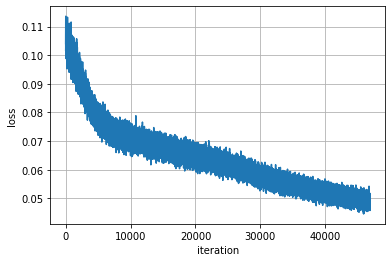

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.xlabel('iteration')
plt.ylabel('loss')
# plt.ylim(0, 300)
plt.grid()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


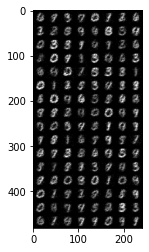

In [11]:
from torchvision.utils import make_grid

images = next(iter(test_loader))[0].to(device)
v = images.view(-1, 784)
output = model(v)
npimg = np.transpose(make_grid(output.view(batch_size, 1, 28, 28).data).cpu().numpy(), (1, 2, 0))
plt.imshow(npimg, cmap="gray")

In [12]:
vv1 = np.zeros((len(train_datasets), n_hid))

for idx, (x, y) in enumerate(train_loader):
    x = x.to(device)
    x = x.view(-1, n_vis)
    vv1[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(x).detach().cpu().numpy() # [batch_size, n_hid]

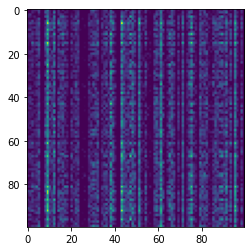

In [13]:
plt.imshow(vv1[:100, :])


In [14]:
import sklearn
from sklearn.decomposition import PCA

vv1 = sklearn.preprocessing.scale(vv1)

In [15]:
pca = PCA()
pca.fit(vv1)
print(pca.explained_variance_)

[1.83196965e+01 1.11316472e+01 1.03185626e+01 9.15648298e+00
 6.75547682e+00 5.11248296e+00 3.12350448e+00 2.28245464e+00
 2.09353214e+00 1.71771387e+00 1.44407981e+00 1.33753415e+00
 1.25232769e+00 1.14334811e+00 1.06561575e+00 1.05099853e+00
 1.04753242e+00 1.02534259e+00 1.01881923e+00 9.66953898e-01
 9.61388029e-01 9.40995971e-01 9.25916370e-01 9.10629969e-01
 8.74749259e-01 8.56899864e-01 8.48384945e-01 8.15217430e-01
 7.71677245e-01 7.49287791e-01 7.44228615e-01 6.76065208e-01
 5.97772611e-01 5.60023912e-01 5.10508153e-01 4.69221276e-01
 4.23716972e-01 3.90099507e-01 3.57012663e-01 3.25784913e-01
 3.04039309e-01 2.82806530e-01 2.76471929e-01 2.53525706e-01
 2.38525881e-01 2.08314370e-01 1.94785184e-01 1.85474247e-01
 1.72571687e-01 1.62350394e-01 1.55475328e-01 1.46032972e-01
 1.38918810e-01 1.28950291e-01 1.21856822e-01 1.18329202e-01
 9.96674082e-02 9.75829771e-02 9.04703401e-02 8.69682477e-02
 8.29688622e-02 8.20275383e-02 7.71856304e-02 7.05911745e-02
 6.45825443e-02 5.973047

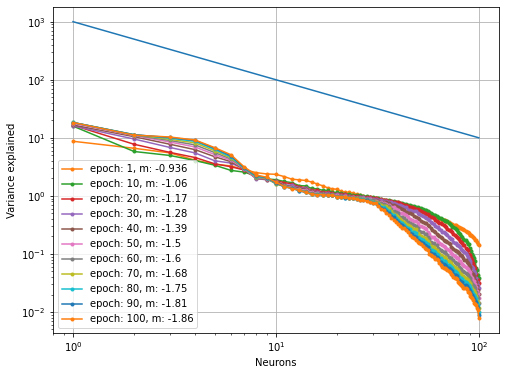

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
log_xx = np.log(xx)
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
for epoch, vv in neuron_fireings:
    vv = sklearn.preprocessing.scale(vv)
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"epoch: {epoch+1}, m: {m:.3}")
plt.legend()
ax.grid()

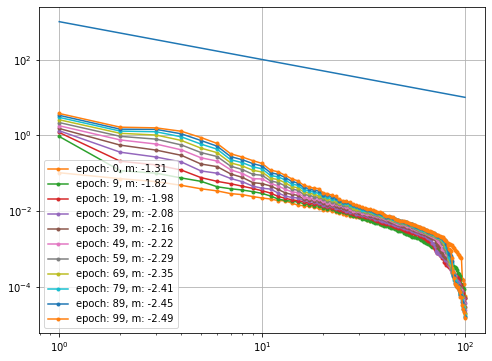

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
log_xx = np.log(xx)
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
for epoch, vv in neuron_fireings:
    # vv = sklearn.preprocessing.scale(vv)
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"epoch: {epoch}, m: {m:.3}")
plt.legend()
ax.grid()

学習前に傾きがあるのは変

学習前は,W, b が正規乱数に従うので,
$$Encoder(x) = Relu(Wx + b)$$
隠れ層の分布も正規分布のはず... TODO: バグチェック